# RAGAS TEST
## 1. VectorDB 비교
#### FAISS-cpu vs ChromaDB
#### 선정 이유
- 접근성
- 로컬 저장
- 성능
- 커뮤니티

In [ ]:
!pip install langchain langchain-openai langchain-chroma langchain-community openai faiss-cpu python-docx dotenv rank_bm25 ragas transformers sentence_transformers

### 환경 변수

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
file_path = os.getenv("FILE_PATH")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_BASE"] = os.getenv("OPENAI_API_BASE")

print("done")

## RAGAS 평가 코드 정의

In [ ]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
import json
from pprint import pprint
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

QA_set = []

# GT 불러오기
try:
    if os.path.exists("ground_truths.json"):
        with open("ground_truths.json", "r", encoding="utf-8") as f:
            ground_truths = json.load(f)
        print("✅ GT 로드 완료")
    else:
        raise FileNotFoundError

    for doc in ground_truths:
        QA_set.append(doc['qa_pairs'])
    else:
        print("Q&A set 생성 완료")
except FileNotFoundError:
    print("❌ GT 파일이 존재하지 않음")

pprint(QA_set[:3])


# VectorDB
- precision
- recall


In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_chroma.vectorstores import Chroma

faiss_store = FAISS.load_local("faiss_store", embeddings=embeddings, allow_dangerous_deserialization=True) if os.path.exists("faiss_store") else None
chroma_store = Chroma(persist_directory="chroma_store", embedding_function=embeddings) if os.path.exists("chroma_store") else None
all_texts = None

if faiss_store is None:
    print("❌FAISS 파일 없음")
elif chroma_store is None:
    print("❌ChromaDB 파일 없음")
else:
    print("✅벡터 DB 로드 완료")




In [28]:
dense_types = ["similarity ", "mmr"]
sparse_types = ["bm25"]
ensemble_types = ["ensemble"]

retriever_types = [dense_types, sparse_types, ensemble_types]

faiss_score = {}
chroma_score = {}

all_texts = [doc.page_content for doc in faiss_store.docstore._dict.values()]
K_VALUE = 5

## 함수 정의


In [29]:
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

"""
검색기 사전 정의, RAGAS 테스트 검색기 별  자동화 완료
함수 : 
ragas_evaluate -> RAGAS 검색기 성능평가 함수

fill_data -> data 채우기

evaluate_retr -> 모든 검색기 자동화 저장 (test 완)
"""


# 점수 계산 함수
def ragas_evaluate(dataset):
    result = evaluate(
        dataset,
        metrics=[
            context_precision,
            context_recall,
        ],
        llm=llm,
        embeddings=embeddings,
    )
    return result

# 데이터
def fill_data(data, question, retr, ground_truth):

    results = retr.invoke(question)
    context = [doc.page_content for doc in results]

    # llm 응답은 기록하지 않음

    data["question"].append(question)
    data["answer"].append("")
    data["contexts"].append(context)
    data["ground_truth"].append(ground_truth)


def evaluate_retr(all_retrievers_map, score, test=False):

    for retr_name, retr in all_retrievers_map.items():
        print(f"/ {retr_name} / 검색 평가 시작")
        _data_frame = {
            "question": [],
            "answer": [],
            "contexts": [],
            "ground_truth": [],
        }

        if test:
            print(f"{retr_name} test")
            fill_data(_data_frame, QA_set[0]["Q"], retr, QA_set[0]["A"])

        else: 
            for idx, qa in enumerate(QA_set):
                fill_data(_data_frame, qa["Q"], retr, qa["A"])
                print(f"✅{idx + 1}/{len(QA_set)}")

        print("start")
        _dataset = Dataset.from_dict(_data_frame)
        score[retr_name] = ragas_evaluate(_dataset)
            
    print("done")



# test start

In [32]:
# bm25
sparse_bm25_retriever = BM25Retriever.from_texts(texts=all_texts)
sparse_bm25_retriever.k = K_VALUE  # k값을 통일하여 설정

# BM25만 독립적으로 평가
bm25_score_dict = {}
evaluate_retr(
    {"bm25": sparse_bm25_retriever}, # BM25만 담긴 맵을 전달
    bm25_score_dict,
)

faiss_score ["bm25"] = bm25_score_dict["bm25"]
chroma_score ["bm25"] = bm25_score_dict["bm25"]
print("--- [ BM25 ] 평가 완료 ---\n")


for db_name, vectordb, vectordb_score in [
    ("FAISS", faiss_store, faiss_score),
    ("CHroma", chroma_store, chroma_score),
]:
    # similarity
    dense_similarity_retriever = vectordb.as_retriever(
        search_type="similarity", search_kwargs={"k": K_VALUE}
    )
    # mmr
    dense_mmr_retriever = vectordb.as_retriever(
        search_type="mmr",
        search_kwargs={"k": K_VALUE, "fetch_k": 20},  # MMR은 fetch_k를 추가로 설정 가능
    )
    # ensemble
    ensemble_retriever = EnsembleRetriever(
        retrievers=[sparse_bm25_retriever, dense_similarity_retriever],
        weights=[0.5, 0.5],  # 가중치 설정
    )

    all_retrievers_map = {
        "similarity": dense_similarity_retriever,
        "mmr": dense_mmr_retriever,
        # "bm25": sparse_bm25_retriever,
        "ensemble": ensemble_retriever,
    }


    evaluate_retr(all_retrievers_map, vectordb_score)



/ bm25 / 검색 평가 시작
✅1/86
✅2/86
✅3/86
✅4/86
✅5/86
✅6/86
✅7/86
✅8/86
✅9/86
✅10/86
✅11/86
✅12/86
✅13/86
✅14/86
✅15/86
✅16/86
✅17/86
✅18/86
✅19/86
✅20/86
✅21/86
✅22/86
✅23/86
✅24/86
✅25/86
✅26/86
✅27/86
✅28/86
✅29/86
✅30/86
✅31/86
✅32/86
✅33/86
✅34/86
✅35/86
✅36/86
✅37/86
✅38/86
✅39/86
✅40/86
✅41/86
✅42/86
✅43/86
✅44/86
✅45/86
✅46/86
✅47/86
✅48/86
✅49/86
✅50/86
✅51/86
✅52/86
✅53/86
✅54/86
✅55/86
✅56/86
✅57/86
✅58/86
✅59/86
✅60/86
✅61/86
✅62/86
✅63/86
✅64/86
✅65/86
✅66/86
✅67/86
✅68/86
✅69/86
✅70/86
✅71/86
✅72/86
✅73/86
✅74/86
✅75/86
✅76/86
✅77/86
✅78/86
✅79/86
✅80/86
✅81/86
✅82/86
✅83/86
✅84/86
✅85/86
✅86/86
start


Evaluating: 100%|██████████| 172/172 [01:35<00:00,  1.80it/s]


done
--- [ BM25 ] 평가 완료 ---

/ similarity / 검색 평가 시작
✅1/86
✅2/86
✅3/86
✅4/86
✅5/86
✅6/86
✅7/86
✅8/86
✅9/86
✅10/86
✅11/86
✅12/86
✅13/86
✅14/86
✅15/86
✅16/86
✅17/86
✅18/86
✅19/86
✅20/86
✅21/86
✅22/86
✅23/86
✅24/86
✅25/86
✅26/86
✅27/86
✅28/86
✅29/86
✅30/86
✅31/86
✅32/86
✅33/86
✅34/86
✅35/86
✅36/86
✅37/86
✅38/86
✅39/86
✅40/86
✅41/86
✅42/86
✅43/86
✅44/86
✅45/86
✅46/86
✅47/86
✅48/86
✅49/86
✅50/86
✅51/86
✅52/86
✅53/86
✅54/86
✅55/86
✅56/86
✅57/86
✅58/86
✅59/86
✅60/86
✅61/86
✅62/86
✅63/86
✅64/86
✅65/86
✅66/86
✅67/86
✅68/86
✅69/86
✅70/86
✅71/86
✅72/86
✅73/86
✅74/86
✅75/86
✅76/86
✅77/86
✅78/86
✅79/86
✅80/86
✅81/86
✅82/86
✅83/86
✅84/86
✅85/86
✅86/86
start


Evaluating: 100%|██████████| 172/172 [01:40<00:00,  1.71it/s]


/ mmr / 검색 평가 시작
✅1/86
✅2/86
✅3/86
✅4/86
✅5/86
✅6/86
✅7/86
✅8/86
✅9/86
✅10/86
✅11/86
✅12/86
✅13/86
✅14/86
✅15/86
✅16/86
✅17/86
✅18/86
✅19/86
✅20/86
✅21/86
✅22/86
✅23/86
✅24/86
✅25/86
✅26/86
✅27/86
✅28/86
✅29/86
✅30/86
✅31/86
✅32/86
✅33/86
✅34/86
✅35/86
✅36/86
✅37/86
✅38/86
✅39/86
✅40/86
✅41/86
✅42/86
✅43/86
✅44/86
✅45/86
✅46/86
✅47/86
✅48/86
✅49/86
✅50/86
✅51/86
✅52/86
✅53/86
✅54/86
✅55/86
✅56/86
✅57/86
✅58/86
✅59/86
✅60/86
✅61/86
✅62/86
✅63/86
✅64/86
✅65/86
✅66/86
✅67/86
✅68/86
✅69/86
✅70/86
✅71/86
✅72/86
✅73/86
✅74/86
✅75/86
✅76/86
✅77/86
✅78/86
✅79/86
✅80/86
✅81/86
✅82/86
✅83/86
✅84/86
✅85/86
✅86/86
start


Evaluating: 100%|██████████| 172/172 [01:28<00:00,  1.94it/s]


/ ensemble / 검색 평가 시작
✅1/86
✅2/86
✅3/86
✅4/86
✅5/86
✅6/86
✅7/86
✅8/86
✅9/86
✅10/86
✅11/86
✅12/86
✅13/86
✅14/86
✅15/86
✅16/86
✅17/86
✅18/86
✅19/86
✅20/86
✅21/86
✅22/86
✅23/86
✅24/86
✅25/86
✅26/86
✅27/86
✅28/86
✅29/86
✅30/86
✅31/86
✅32/86
✅33/86
✅34/86
✅35/86
✅36/86
✅37/86
✅38/86
✅39/86
✅40/86
✅41/86
✅42/86
✅43/86
✅44/86
✅45/86
✅46/86
✅47/86
✅48/86
✅49/86
✅50/86
✅51/86
✅52/86
✅53/86
✅54/86
✅55/86
✅56/86
✅57/86
✅58/86
✅59/86
✅60/86
✅61/86
✅62/86
✅63/86
✅64/86
✅65/86
✅66/86
✅67/86
✅68/86
✅69/86
✅70/86
✅71/86
✅72/86
✅73/86
✅74/86
✅75/86
✅76/86
✅77/86
✅78/86
✅79/86
✅80/86
✅81/86
✅82/86
✅83/86
✅84/86
✅85/86
✅86/86
start


Evaluating: 100%|██████████| 172/172 [01:54<00:00,  1.51it/s]


done
/ similarity / 검색 평가 시작
✅1/86
✅2/86
✅3/86
✅4/86
✅5/86
✅6/86
✅7/86
✅8/86
✅9/86
✅10/86
✅11/86
✅12/86
✅13/86
✅14/86
✅15/86
✅16/86
✅17/86
✅18/86
✅19/86
✅20/86
✅21/86
✅22/86
✅23/86
✅24/86
✅25/86
✅26/86
✅27/86
✅28/86
✅29/86
✅30/86
✅31/86
✅32/86
✅33/86
✅34/86
✅35/86
✅36/86
✅37/86
✅38/86
✅39/86
✅40/86
✅41/86
✅42/86
✅43/86
✅44/86
✅45/86
✅46/86
✅47/86
✅48/86
✅49/86
✅50/86
✅51/86
✅52/86
✅53/86
✅54/86
✅55/86
✅56/86
✅57/86
✅58/86
✅59/86
✅60/86
✅61/86
✅62/86
✅63/86
✅64/86
✅65/86
✅66/86
✅67/86
✅68/86
✅69/86
✅70/86
✅71/86
✅72/86
✅73/86
✅74/86
✅75/86
✅76/86
✅77/86
✅78/86
✅79/86
✅80/86
✅81/86
✅82/86
✅83/86
✅84/86
✅85/86
✅86/86
start


Evaluating: 100%|██████████| 172/172 [01:23<00:00,  2.07it/s]


/ mmr / 검색 평가 시작
✅1/86
✅2/86
✅3/86
✅4/86
✅5/86
✅6/86
✅7/86
✅8/86
✅9/86
✅10/86
✅11/86
✅12/86
✅13/86
✅14/86
✅15/86
✅16/86
✅17/86
✅18/86
✅19/86
✅20/86
✅21/86
✅22/86
✅23/86
✅24/86
✅25/86
✅26/86
✅27/86
✅28/86
✅29/86
✅30/86
✅31/86
✅32/86
✅33/86
✅34/86
✅35/86
✅36/86
✅37/86
✅38/86
✅39/86
✅40/86
✅41/86
✅42/86
✅43/86
✅44/86
✅45/86
✅46/86
✅47/86
✅48/86
✅49/86
✅50/86
✅51/86
✅52/86
✅53/86
✅54/86
✅55/86
✅56/86
✅57/86
✅58/86
✅59/86
✅60/86
✅61/86
✅62/86
✅63/86
✅64/86
✅65/86
✅66/86
✅67/86
✅68/86
✅69/86
✅70/86
✅71/86
✅72/86
✅73/86
✅74/86
✅75/86
✅76/86
✅77/86
✅78/86
✅79/86
✅80/86
✅81/86
✅82/86
✅83/86
✅84/86
✅85/86
✅86/86
start


Evaluating: 100%|██████████| 172/172 [01:28<00:00,  1.95it/s]


/ ensemble / 검색 평가 시작
✅1/86
✅2/86
✅3/86
✅4/86
✅5/86
✅6/86
✅7/86
✅8/86
✅9/86
✅10/86
✅11/86
✅12/86
✅13/86
✅14/86
✅15/86
✅16/86
✅17/86
✅18/86
✅19/86
✅20/86
✅21/86
✅22/86
✅23/86
✅24/86
✅25/86
✅26/86
✅27/86
✅28/86
✅29/86
✅30/86
✅31/86
✅32/86
✅33/86
✅34/86
✅35/86
✅36/86
✅37/86
✅38/86
✅39/86
✅40/86
✅41/86
✅42/86
✅43/86
✅44/86
✅45/86
✅46/86
✅47/86
✅48/86
✅49/86
✅50/86
✅51/86
✅52/86
✅53/86
✅54/86
✅55/86
✅56/86
✅57/86
✅58/86
✅59/86
✅60/86
✅61/86
✅62/86
✅63/86
✅64/86
✅65/86
✅66/86
✅67/86
✅68/86
✅69/86
✅70/86
✅71/86
✅72/86
✅73/86
✅74/86
✅75/86
✅76/86
✅77/86
✅78/86
✅79/86
✅80/86
✅81/86
✅82/86
✅83/86
✅84/86
✅85/86
✅86/86
start


Evaluating: 100%|██████████| 172/172 [02:21<00:00,  1.21it/s]


done


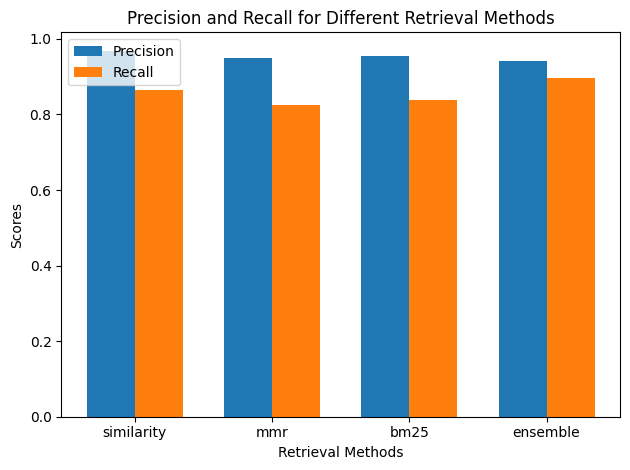

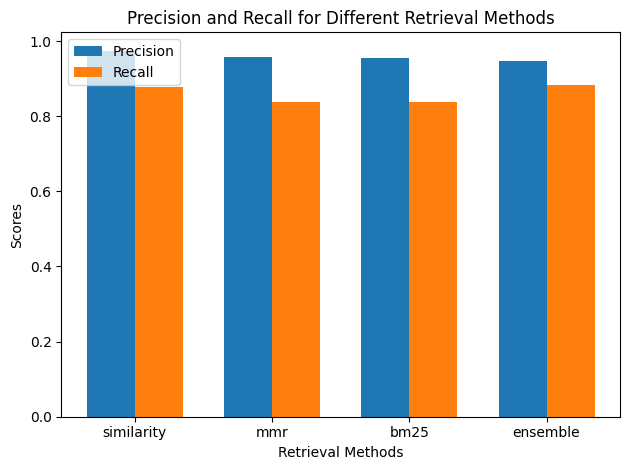

---faiss---
{'bm25': {'context_precision': 0.9545, 'context_recall': 0.8372},
 'ensemble': {'context_precision': 0.9424, 'context_recall': 0.8959},
 'mmr': {'context_precision': 0.9501, 'context_recall': 0.8244},
 'similarity': {'context_precision': 0.9690, 'context_recall': 0.8636}}
---chroma---
{'bm25': {'context_precision': 0.9545, 'context_recall': 0.8372},
 'ensemble': {'context_precision': 0.9470, 'context_recall': 0.8837},
 'mmr': {'context_precision': 0.9578, 'context_recall': 0.8384},
 'similarity': {'context_precision': 0.9745, 'context_recall': 0.8779}}


In [33]:
import matplotlib.pyplot as plt
import numpy as np

methods = ["similarity", "mmr", "bm25", "ensemble"]

for score in [faiss_score, chroma_score]:

    precision = [np.nanmean(score[type_name]['context_precision']) for type_name in methods]
    recall = [np.nanmean(score[type_name]['context_recall']) for type_name in methods]

    # 시각화
    fig, ax = plt.subplots()

    # Precision과 Recall을 나란히 보여주기 위해 bar width 설정
    bar_width = 0.35
    index = range(len(methods))

    # Precision과 Recall Bar 생성
    bar1 = ax.bar(index, precision, bar_width, label='Precision')
    bar2 = ax.bar([i + bar_width for i in index], recall, bar_width, label='Recall')

    # Label 및 제목 설정
    ax.set_xlabel('Retrieval Methods')
    ax.set_ylabel('Scores')
    ax.set_title('Precision and Recall for Different Retrieval Methods')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(methods)
    ax.legend()

    # 그래프 출력
    plt.tight_layout()
    plt.show()

    
print("---faiss---")
pprint(faiss_score)
print("---chroma---")
pprint(chroma_score)